In [1]:
# Imports
import os, json, glob, subprocess, datetime as dt
from pathlib import Path

import requests
import polars as pl
import pyarrow.dataset as ds
import matplotlib.pyplot as plt

In [2]:
# Paths on the EXTERNAL drive
PARQUET_DIR = Path("/media/vatereal/Main/parquet")
OUTPUT_DIR  = Path("/media/vatereal/Main/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Polars display
pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(80)

polars.config.Config

In [3]:
patterns = {
    "blocks": str(PARQUET_DIR / "blocks/day=*/blocks-*.parquet"),
    "txs":    str(PARQUET_DIR / "txs/day=*/txs-*.parquet"),
    "io":     str(PARQUET_DIR / "io/day=*/io-*.parquet"),
}
print({k: len(glob.glob(v)) for k,v in patterns.items()})

{'blocks': 1703, 'txs': 1703, 'io': 1703}


In [4]:
blocks_lf = pl.scan_parquet(patterns["blocks"], hive_partitioning=True)
txs_lf    = pl.scan_parquet(patterns["txs"],    hive_partitioning=True)
io_lf     = pl.scan_parquet(patterns["io"],     hive_partitioning=True)

In [5]:
# Quick peek
def peek(lf, n=5):
    return lf.limit(n).collect(streaming=True)

print("blocks cols:", blocks_lf.columns)
print(peek(blocks_lf))
print("txs cols:", txs_lf.columns)
print(peek(txs_lf))
print("io cols:", io_lf.columns)
print(peek(io_lf))

/tmp/ipykernel_12809/3687481013.py:5: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  print("blocks cols:", blocks_lf.columns)


blocks cols: ['height', 'block_hash', 'time', 'tx_count', 'size', 'weight', 'day']


/tmp/ipykernel_12809/3687481013.py:3: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  return lf.limit(n).collect(streaming=True)


shape: (5, 7)
┌────────┬───────────────────────────┬─────────────────────┬──────────┬──────┬────────┬────────────┐
│ height ┆ block_hash                ┆ time                ┆ tx_count ┆ size ┆ weight ┆ day        │
│ ---    ┆ ---                       ┆ ---                 ┆ ---      ┆ ---  ┆ ---    ┆ ---        │
│ i64    ┆ str                       ┆ datetime[ns]        ┆ i64      ┆ i64  ┆ i64    ┆ date       │
╞════════╪═══════════════════════════╪═════════════════════╪══════════╪══════╪════════╪════════════╡
│ 0      ┆ 000000000019d6689c085ae16 ┆ 2009-01-03 18:15:05 ┆ 1        ┆ 285  ┆ 1140   ┆ 2009-01-03 │
│        ┆ 5831e934ff763ae46a2a6c172 ┆                     ┆          ┆      ┆        ┆            │
│        ┆ b3f1b60a8ce26f            ┆                     ┆          ┆      ┆        ┆            │
│ 1      ┆ 00000000839a8e6886ab5951d ┆ 2009-01-09 02:54:25 ┆ 1        ┆ 215  ┆ 860    ┆ 2009-01-09 │
│        ┆ 76f411475428afc90947ee320 ┆                     ┆          ┆      

/tmp/ipykernel_12809/3687481013.py:7: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  print("txs cols:", txs_lf.columns)
/tmp/ipykernel_12809/3687481013.py:9: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  print("io cols:", io_lf.columns)


In [6]:
# ---- helpers ----
def colnames(lf: pl.LazyFrame) -> list[str]:
    return list(lf.collect_schema().names())

def first_col(cols, candidates):
    s = set(cols)
    for c in candidates:
        if c in s:
            return c
    return None

def day_expr(lf: pl.LazyFrame, colname: str):
    dtype = lf.collect_schema().get(colname)
    c = pl.col(colname)
    if dtype in (pl.Datetime, pl.Date):
        return c.dt.truncate("1d")
    if dtype in (pl.Int64, pl.Int32, pl.UInt64, pl.UInt32):
        # assume seconds since epoch (change to unit="ms" if needed)
        return pl.from_epoch(c, unit="s").dt.truncate("1d")
    if dtype == pl.Utf8:
        return c.str.strptime(pl.Datetime, strict=False).dt.truncate("1d")
    return c.cast(pl.Datetime, strict=False).dt.truncate("1d")


In [7]:
def lineplot(df: pl.DataFrame, x, y, title, logy=False):
    plt.figure(figsize=(10,4))
    pd = df.to_pandas()
    plt.plot(pd[x], pd[y])
    plt.title(title)
    plt.xlabel(str(x)); plt.ylabel(str(y))
    if logy: plt.yscale("log")
    plt.tight_layout(); plt.show()

def barplot(df: pl.DataFrame, x, y, title):
    plt.figure(figsize=(8,4))
    pd = df.to_pandas()
    plt.bar(pd[x], pd[y])
    plt.title(title)
    plt.xlabel(str(x)); plt.ylabel(str(y))
    plt.tight_layout(); plt.show()

def histplot(series: pl.Series, bins=50, title="Histogram", logx=False, logy=False):
    plt.figure(figsize=(8,4))
    x = series.drop_nulls().to_numpy()
    if logx:
        import numpy as np
        x = x[x>0]
        x = np.log10(x)
    plt.hist(x, bins=bins)
    plt.title(title)
    if logx: plt.xlabel("log10(value)")
    else:    plt.xlabel("value")
    if logy: plt.yscale("log")
    plt.tight_layout(); plt.show()

Daily tx (tail):
shape: (5, 3)
┌─────────────────────┬──────────┬──────────────┐
│ day                 ┆ tx_count ┆ tx_count_ma7 │
│ ---                 ┆ ---      ┆ ---          │
│ datetime[ns]        ┆ u32      ┆ f64          │
╞═════════════════════╪══════════╪══════════════╡
│ 2012-12-05 00:00:00 ┆ 33744    ┆ 29862.571429 │
│ 2012-12-06 00:00:00 ┆ 37163    ┆ 29825.428571 │
│ 2012-12-07 00:00:00 ┆ 32145    ┆ 30166.428571 │
│ 2012-12-08 00:00:00 ┆ 33174    ┆ 30121.0      │
│ 2012-12-09 00:00:00 ┆ 989      ┆ 27318.571429 │
└─────────────────────┴──────────┴──────────────┘


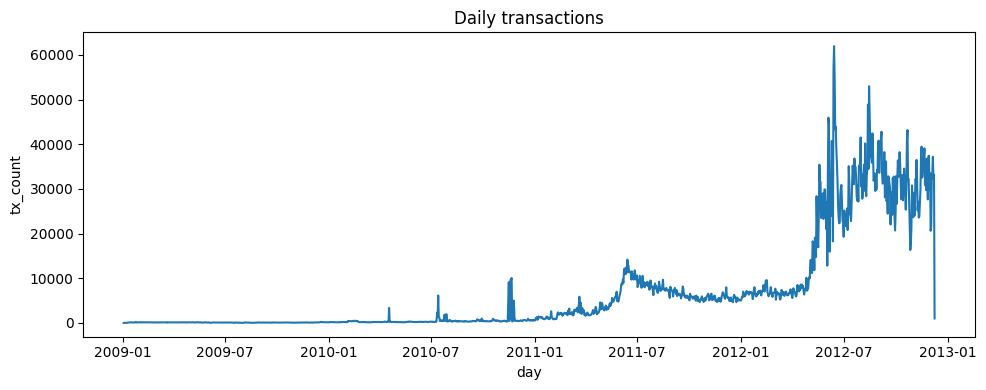

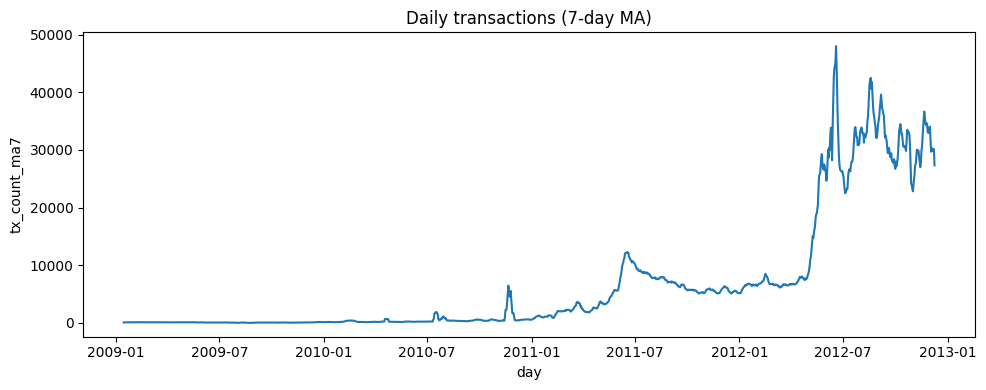

In [8]:
# ===== 1) Daily transactions (with 7d MA) =====
tx_cols = colnames(txs_lf)
blk_cols = colnames(blocks_lf)

tx_time_col = first_col(tx_cols, ["tx_time","block_time","time","timestamp","ts","datetime"])
if tx_time_col:
    daily_tx = (
        txs_lf
        .with_columns(day = day_expr(txs_lf, tx_time_col))
        .group_by("day").agg(pl.len().alias("tx_count"))
        .sort("day")
        .with_columns(pl.col("tx_count").rolling_mean(window_size=7).alias("tx_count_ma7"))
        .collect()
    )
else:
    n_tx_col     = first_col(blk_cols, ["n_tx","tx_count","txs"])
    blk_time_col = first_col(blk_cols, ["block_time","time","timestamp","ts","datetime","day"])
    daily_tx = (
        blocks_lf
        .with_columns(day = day_expr(blocks_lf, blk_time_col))
        .group_by("day").agg(pl.col(n_tx_col).sum().alias("tx_count"))
        .sort("day")
        .with_columns(pl.col("tx_count").rolling_mean(window_size=7).alias("tx_count_ma7"))
        .collect()
    )

print("Daily tx (tail):"); print(daily_tx.tail(5))
lineplot(daily_tx, "day", "tx_count", "Daily transactions")
lineplot(daily_tx, "day", "tx_count_ma7", "Daily transactions (7-day MA)")


In [9]:
# ===== 2) Daily output volume in BTC (and MA) =====
io_cols = colnames(io_lf)

# value in BTC
if "value_btc" in io_cols:        val_expr = pl.col("value_btc")
elif "amount_btc" in io_cols:     val_expr = pl.col("amount_btc")
elif "value_sats" in io_cols:     val_expr = pl.col("value_sats") / 1e8
elif "satoshis" in io_cols:       val_expr = pl.col("satoshis") / 1e8
else:                             val_expr = None

if val_expr is not None:
    # outputs only
    if "is_output" in io_cols:      out_mask = pl.col("is_output")
    elif "is_input" in io_cols:     out_mask = ~pl.col("is_input")
    elif "io_type" in io_cols:      out_mask = (pl.col("io_type") == "out")
    elif "direction" in io_cols:    out_mask = (pl.col("direction") == "out")
    else:                           out_mask = pl.lit(True)

    ts_col = first_col(io_cols, ["block_time","tx_time","time","timestamp","ts","datetime","day"])
    daily_vol = (
        io_lf
        .with_columns(day = day_expr(io_lf, ts_col))
        .filter(out_mask)
        .group_by("day").agg(pl.sum(val_expr).alias("volume_btc"))
        .sort("day")
        .with_columns(pl.col("volume_btc").rolling_mean(window_size=7).alias("volume_btc_ma7"))
        .collect()
    )
    print("Daily volume (tail):"); print(daily_vol.tail(5))
    lineplot(daily_vol, "day", "volume_btc",     "Daily on-chain output volume (BTC)", logy=True)
    lineplot(daily_vol, "day", "volume_btc_ma7", "Daily on-chain output volume (BTC, 7-day MA)", logy=True)
else:
    print("No value column in io parquet; skipping volume plots.")

No value column in io parquet; skipping volume plots.


Inter-block intervals: n=211346


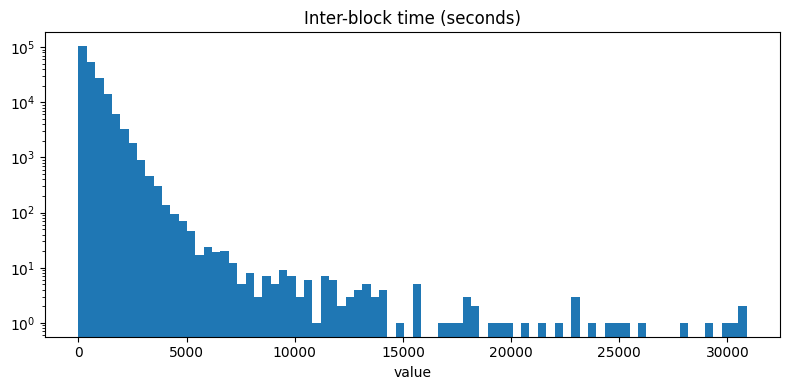

In [10]:
# ===== 3) Inter-block time histogram (fixed: don't truncate to day) =====
blk_time_col = first_col(blk_cols, ["block_time","time","timestamp","ts","datetime"])
if blk_time_col:
    # Build a proper datetime expression from the source column
    dtypes = blocks_lf.collect_schema()
    dt = dtypes.get(blk_time_col)
    col = pl.col(blk_time_col)

    if dt == pl.Datetime:
        ts_expr = col
    elif dt in (pl.Int64, pl.Int32, pl.UInt64, pl.UInt32):
        # heuristic: >1e11 → milliseconds; else seconds
        unix_s = pl.when(col > 100_000_000_000).then((col / 1000).cast(pl.Int64)).otherwise(col.cast(pl.Int64))
        ts_expr = pl.from_epoch(unix_s, time_unit="s")
    elif dt == pl.Date:
        # only day precision available; we cannot compute seconds reliably
        print("Block time has only day precision; skipping inter-block histogram.")
        ts_expr = None
    else:
        ts_expr = col.cast(pl.Datetime)

    if ts_expr is not None:
        block_times = (
            blocks_lf
            .select(ts_expr.alias("ts"))
            .sort("ts")
            .with_columns(pl.col("ts").diff().dt.total_seconds().alias("delta_s"))
            .select("delta_s")
            .filter(pl.col("delta_s").is_not_null() & (pl.col("delta_s") > 0) & (pl.col("delta_s") < 36_000))
            .collect()
            .get_column("delta_s")
        )
        print(f"Inter-block intervals: n={len(block_times)}")
        if len(block_times) > 0:
            histplot(block_times, bins=80, title="Inter-block time (seconds)", logy=True)
        else:
            print("No intervals survived the filters; check timestamp units.")
else:
    print("No block timestamp found; skipping inter-block histogram.")


No fee fields present; skipping fee plots.
Avg tx per weekday:
shape: (7, 2)
┌─────────┬─────────────┐
│ weekday ┆ avg_tx      │
│ ---     ┆ ---         │
│ i8      ┆ f64         │
╞═════════╪═════════════╡
│ 1       ┆ 6970.470588 │
│ 2       ┆ 6989.29902  │
│ 3       ┆ 7081.504902 │
│ 4       ┆ 6838.72549  │
│ 5       ┆ 6697.95122  │
│ 6       ┆ 6373.320388 │
│ 7       ┆ 6354.073171 │
└─────────┴─────────────┘


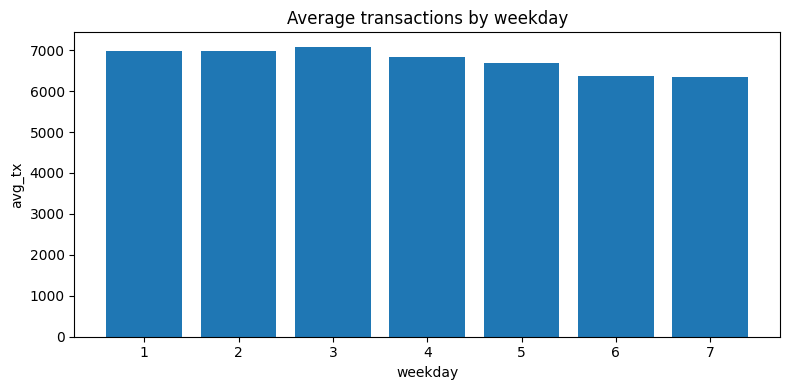

In [11]:
# ===== 4) Fees per day (BTC) & fee-rate histogram =====
fee_btc_col  = first_col(tx_cols, ["fee_btc","fees_btc"])
fee_sat_col  = first_col(tx_cols, ["fee_sats","fees_sats"])
size_col     = first_col(tx_cols, ["vsize","virtual_size","size_vb","size"])
weight_col   = first_col(tx_cols, ["weight","witness_weight"])

tx_time_col2 = tx_time_col or blk_time_col
if (fee_btc_col or fee_sat_col) and tx_time_col2:
    fee_expr = pl.col(fee_btc_col) if fee_btc_col else (pl.col(fee_sat_col)/1e8)
    fees_daily = (
        txs_lf
        .with_columns(day = day_expr(txs_lf, tx_time_col2))
        .group_by("day").agg(pl.sum(fee_expr).alias("fees_btc"))
        .sort("day")
        .with_columns(pl.col("fees_btc").rolling_mean(window_size=7).alias("fees_btc_ma7"))
        .collect()
    )
    print("Fees daily (tail):"); print(fees_daily.tail(5))
    lineplot(fees_daily, "day", "fees_btc",     "Total fees per day (BTC)", logy=True)
    lineplot(fees_daily, "day", "fees_btc_ma7", "Total fees per day (BTC, 7-day MA)", logy=True)

    # fee rate (sat/vB) histogram if possible
    if fee_sat_col and (size_col or weight_col):
        if size_col:
            vbytes = pl.col(size_col).cast(pl.Float64)
        else:
            vbytes = (pl.col(weight_col) / 4).cast(pl.Float64)
        fee_rate = (
            txs_lf
            .select((pl.col(fee_sat_col).cast(pl.Float64) / vbytes).alias("sat_per_vb"))
            .filter(pl.col("sat_per_vb").is_finite() & (pl.col("sat_per_vb") > 0) & (pl.col("sat_per_vb") < 5000))
            .limit(5_000_000)  # cap for quick plotting if huge
            .collect()
            .get_column("sat_per_vb")
        )
        histplot(fee_rate, bins=120, title="Tx fee rate (sat/vB)", logx=True, logy=True)
else:
    print("No fee fields present; skipping fee plots.")

# ===== 5) Day-of-week pattern in tx count =====
dow = (
    daily_tx
    .with_columns(pl.col("day").dt.weekday().alias("weekday"))  # 0=Mon
    .group_by("weekday")
    .agg(pl.col("tx_count").mean().alias("avg_tx"))
    .sort("weekday")
)
print("Avg tx per weekday:"); print(dow)
barplot(dow, "weekday", "avg_tx", "Average transactions by weekday")

# If the node is fully up and loaded

In [ ]:
# RPC (HTTP first, fallback to docker exec bitcoin-cli)
RPC_URL  = "http://127.0.0.1:8332"
RPC_USER = "research"
RPC_PASS = "researchpass"

def _cid() -> str:
    try:
        return subprocess.check_output(
            ["bash","-lc","docker compose -f ~/btc-node/docker-compose.yml ps -q bitcoind"],
            text=True
        ).strip()
    except Exception:
        return ""

def rpc(method: str, params=None, timeout: int = 30):
    try:
        r = requests.post(
            RPC_URL,
            json={"jsonrpc":"1.0","id":"nb","method":method,"params":params or []},
            auth=(RPC_USER, RPC_PASS),
            timeout=timeout
        )
        r.raise_for_status()
        j = r.json()
        if j.get("error"):
            raise RuntimeError(j["error"])
        return j["result"]
    except Exception as e_http:
        cid = _cid()
        if not cid:
            raise ConnectionError(f"RPC HTTP failed and container not found: {e_http}") from e_http
        cmd = ["docker","exec","-i",cid,"bitcoin-cli",
               f"-rpcuser={RPC_USER}", f"-rpcpassword={RPC_PASS}", method]
        for p in (params or []):
            cmd.append(json.dumps(p) if isinstance(p,(dict,list)) else str(p))
        out = subprocess.check_output(cmd, text=True).strip()
        try:
            return json.loads(out)
        except Exception:
            return out

# Quick check (won't crash the notebook if RPC is down)
try:
    info = rpc("getblockchaininfo")
    print("chain:", info["chain"], "| node height:", info["blocks"])
except Exception as e:
    print("RPC check failed:", e)

In [ ]:
# Base datasets from your ETL
blocks_lf = pl.scan_parquet(str(PARQUET_DIR / "blocks/day=*/blocks-*.parquet"))
txs_lf    = pl.scan_parquet(str(PARQUET_DIR / "txs/day=*/txs-*.parquet"))
io_lf     = pl.scan_parquet(str(PARQUET_DIR / "io/day=*/io-*.parquet"))

# Prefer derived path for io_enriched if you created it; else fall back to legacy layout if present
ioe_candidates = [
    str(PARQUET_DIR / "derived/io_enriched/day=*/ioen.parquet"),
    str(PARQUET_DIR / "io_enriched/day=*/ioen-*.parquet"),
]
ioe_glob = next((g for g in ioe_candidates if glob.glob(g)), None)
ioe_lf   = pl.scan_parquet(ioe_glob) if ioe_glob else None

print("Scans ready.", " (io_enriched found)" if ioe_lf is not None else "(no io_enriched yet)")

In [ ]:
# ------------------------------------------------------------------------------
# Helpers: schema & quick counts
# ------------------------------------------------------------------------------
def show_schema(lf: pl.LazyFrame, name: str):
    schema = lf.collect_schema()
    print(f"\n## {name} schema")
    for col, dtype in schema.items():
        print(f"  {col}: {dtype}")

def quick_counts(lf: pl.LazyFrame, name: str, max_cols: int = 6):
    schema = lf.collect_schema()
    cols = list(schema.keys())[:max_cols]
    res = (
        lf.select(
            [pl.len().alias("rows")] +
            [pl.col(c).is_null().sum().alias(f"{c}__nulls") for c in cols]
        )
        .collect(engine="streaming")
    )
    print(f"\n## {name} — rows & nulls (first {len(cols)} cols)")
    display(res)

def has_columns(lf: pl.LazyFrame, *cols: str) -> bool:
    sch = lf.collect_schema()
    return all(c in sch for c in cols)

In [ ]:
show_schema(blocks_lf, "blocks")
quick_counts(blocks_lf, "blocks")

In [ ]:
show_schema(txs_lf, "txs")
quick_counts(txs_lf, "txs")

In [ ]:
show_schema(io_lf, "io")
quick_counts(io_lf, "io")

In [ ]:
if ioe_lf is not None:
    show_schema(ioe_lf, "io_enriched")
    quick_counts(ioe_lf, "io_enriched")

In [ ]:
# Blocks per day
blocks_daily = (
    blocks_lf
    .with_columns(pl.col("time").dt.date().alias("day"))
    .group_by("day")
    .agg(pl.len().alias("blocks"))
    .sort("day")
).collect(engine="streaming")

# TXs per day
txs_daily = (
    txs_lf
    .with_columns(pl.col("time").dt.date().alias("day"))
    .group_by("day")
    .agg(pl.len().alias("txs"))
    .sort("day")
).collect(engine="streaming")

display(blocks_daily.tail(10))
display(txs_daily.tail(10))

# Matplotlib plots (convert to numpy/pandas for plotting)
bd_day = blocks_daily["day"].to_pandas()
bd_cnt = blocks_daily["blocks"].to_pandas()

td_day = txs_daily["day"].to_pandas()
td_cnt = txs_daily["txs"].to_pandas()

plt.figure(figsize=(10,4))
plt.plot(bd_day, bd_cnt)
plt.title("Blocks per day"); plt.xlabel("Day"); plt.ylabel("Blocks"); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(td_day, td_cnt)
plt.title("Transactions per day"); plt.xlabel("Day"); plt.ylabel("Transactions"); plt.tight_layout(); plt.show()


In [ ]:
# For huge datasets, consider restricting by day range, e.g. last N days
# io_recent = io_lf.filter(pl.col("time") >= pl.lit(pl.datetime(2013,1,1)))

if has_columns(io_lf, "address", "dir"):
    top_addrs = (
        io_lf
        .filter((pl.col("dir")=="out") & pl.col("address").is_not_null())
        .group_by("address").len()
        .sort("len", descending=True)
        .limit(25)
    ).collect(engine="streaming")

    display(top_addrs)
    top_addrs.write_csv(OUTPUT_DIR / "top_output_addresses.csv")
else:
    print("io_lf is missing 'address' or 'dir' columns (older ETL or different schema?).")


In [ ]:
if has_columns(io_lf, "value", "dir", "time"):
    out_value_daily = (
        io_lf
        .filter((pl.col("dir")=="out") & pl.col("value").is_not_null())
        .with_columns(pl.col("time").dt.date().alias("day"))
        .group_by("day")
        .agg(pl.sum("value").alias("total_btc"))
        .sort("day")
    ).collect(engine="streaming")

    display(out_value_daily.tail(10))
    out_value_daily.write_csv(OUTPUT_DIR / "outputs_value_daily.csv")

    ov_day = out_value_daily["day"].to_pandas()
    ov_btc = out_value_daily["total_btc"].to_pandas()

    plt.figure(figsize=(10,4))
    plt.plot(ov_day, ov_btc)
    plt.title("Sum of output values per day (BTC)")
    plt.xlabel("Day"); plt.ylabel("BTC"); plt.tight_layout(); plt.show()
else:
    print("io_lf is missing 'value' / 'dir' / 'time' columns.")


In [ ]:
SAT = 100_000_000

def script_type_expr(addr_col: str = "address") -> pl.Expr:
    """
    Classify script type from address prefix.
    Mainnet: 1 (P2PKH), 3 (P2SH), bc1q (v0 segwit), bc1p (taproot)
    Testnet: m/n (P2PKH), 2 (P2SH), tb1q (v0 segwit), tb1p (taproot)
    """
    a = pl.col(addr_col).cast(pl.Utf8)
    return (
        pl.when(a.is_null() | (a == ""))
          .then(pl.lit(None, dtype=pl.Utf8))
        .when(a.str.starts_with(("bc1p","tb1p"))).then(pl.lit("p2tr"))          # Taproot
        .when(a.str.starts_with(("bc1q","tb1q"))).then(pl.lit("v0_segwit"))     # P2WPKH/P2WSH
        .when(a.str.starts_with(("1","m","n"))).then(pl.lit("p2pkh"))           # legacy PKH
        .when(a.str.starts_with(("3","2"))).then(pl.lit("p2sh"))                # legacy SH
        .otherwise(pl.lit("other"))
    )

def ensure_outs_kv(io: pl.LazyFrame) -> pl.LazyFrame:
    """
    Keep only outputs (dir='out'), ensure numeric value, add value_sat and script_type.
    """
    return (
        io.filter(pl.col("dir") == "out")
          .with_columns([
              pl.col("value").cast(pl.Float64),
              (pl.col("value") * SAT).round(0).cast(pl.Int64).alias("value_sat"),
              script_type_expr("address").alias("script_type"),
          ])
    )

def enrich_day(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns([
        pl.col("time").dt.date().alias("day"),
        pl.col("time").dt.year().alias("year"),
        pl.col("time").dt.month().alias("month"),
    ])


In [ ]:
io_out_lf = ensure_outs_kv(io_lf)
io_out_day_lf = enrich_day(io_out_lf)

print("Enriched outputs lazyframe ready.")


In [ ]:
# Top output addresses (counts). Heavy — consider filtering by date if needed.
if all(col in io_out_lf.collect_schema() for col in ("address",)):
    top_addrs = (
        io_out_lf
        .filter(pl.col("address").is_not_null())
        .group_by("address")
        .len()
        .sort("len", descending=True)
        .limit(25)
    ).collect(engine="streaming")
    display(top_addrs)
    top_addrs.write_csv(OUTPUT_DIR / "top_output_addresses.csv")
else:
    print("Enriched outputs missing 'address' column.")


In [ ]:
# Overall per-day totals
out_value_daily = (
    io_out_day_lf
    .group_by("day")
    .agg([
        pl.sum("value").alias("total_btc"),
        pl.sum("value_sat").alias("total_sat"),
        pl.count().alias("n_outs"),
    ])
    .sort("day")
).collect(engine="streaming")

display(out_value_daily.tail(10))
out_value_daily.write_csv(OUTPUT_DIR / "outputs_value_daily.csv")

# Plot (convert to pandas for Matplotlib)
ov_day = out_value_daily["day"].to_pandas()
ov_btc = out_value_daily["total_btc"].to_pandas()

plt.figure(figsize=(10,4))
plt.plot(ov_day, ov_btc)
plt.title("Sum of output values per day (BTC)")
plt.xlabel("Day"); plt.ylabel("BTC"); plt.tight_layout(); plt.show()

# Optional: breakdown by script_type (daily)
out_value_daily_by_type = (
    io_out_day_lf
    .group_by(["day","script_type"])
    .agg(pl.sum("value_sat").alias("total_sat"))
    .sort(["day","script_type"])
).collect(engine="streaming")

display(out_value_daily_by_type.tail(20))
out_value_daily_by_type.write_csv(OUTPUT_DIR / "outputs_value_daily_by_script_type.csv")


In [ ]:
instead of loading to the home root folder on my ubuntu lets try laoding all on the remote hosting or external disk /media/vatereal/ESD-USB